# Sparse Attribution Prior
This notebook demonstrates how the sparse attribution prior can build sparser models that exhibit better performance when training data is limited.

### Data
The data for these experiments comes from the NHANES I study, which measured a wide array of physiological data (113 variables after one-hot encoding) in 13,000 patients, as well as various outcomes 10 years later. We demonstrate the effectiveness of sparse models by testing their ability to learn from extremely limited training data -- in this case, only 100 training and 100 validation patients.

### How to run
First, execute the Python script in this directory: `python run_sparsity_experiments.py`. This will produce results in the `results/` directory. To process these results and display plots, run this notebook.

Re-executing the `run_sparsity_experiments.py` script with many different random seeds (set at the top of the file) and then running this notebook will replicate the results shown in the maintext.

In [1]:
from matplotlib import pyplot as plt; plt.ion()
import pandas as pd
import numpy as np
import os
from matplotlib.path import Path
import seaborn as sns
import matplotlib.patches as patches
from sklearn.utils.extmath import stable_cumsum

In [2]:
DATADIR = './results/'

In [3]:
files = [f for f in os.listdir(DATADIR) if 'results' in f]

In [4]:
fstring = 'results-%s-%s-%d.csv'

In [5]:
methods = ['gini','ginigrad','l1grad','l1','sgl','newsgl','unreg']

# Expanded names for methods
main_map = {
    'gini': 'Sparse\nAttr Prior',
    'ginigrad': 'Gini:\nGrad',
    'l1grad': 'L1:\nGrad',
    'l1': "L1:\nAll",
    'sgl': "SGL:\n1st",
    'newsgl': 'SGL:\nAll',#"Sparse Grp\nLasso",
    'unreg': "Unreg"
}
# Map colors to methods for plotting
color_map = {
    'gini': 'cornflowerblue',
    'ginigrad': 'navy',
    'l1grad': 'purple',
    'l1': "firebrick",
    'sgl': "lightgreen",
    'newsgl': "green",
    'unreg': "gray"
}

In [19]:
# If running multiple times, may need to exclude inds that throw FileNotFoundErrors
# (implies that a run for that index didn't complete)
inds = np.unique([int(f.split('-')[3].split('.')[0]) for f in files])

In [20]:
# Hyperparameter tuning results (validation data)
results = {k: 
           [pd.read_csv(DATADIR+fstring%('validation',k,i))
           for i in inds]
           for k in methods}

# Results for fixed optimal hyperparameters (results on validation and test data)
testresults = {k: 
           [pd.read_csv(DATADIR+fstring%('test',k,i))
           for i in inds]
           for k in methods}

# EG attributions for fixed optimal hyperparameters on test data
testshaps = {k:
        [pd.read_csv(DATADIR+fstring%('testshap',k,i))
             for i in inds]
             for k in methods}

In [21]:
# All these functions find the best model hyperparameters on validation data, then
# get a corresponding statistic of interest for that model:

# Test ROC
def topbyval(df):
    ind = np.where(df['roc']==np.nanmax(df['roc']))[0][0]
    return df['finalroc'].iloc[ind]

# Sparsity (Gini Coefficient)
def topbyval_sparsity(df):
    ind = np.where(df['roc']==np.nanmax(df['roc']))[0][0]
    return df['gini'].iloc[ind]

# Global EG feature importances
def topbyval_shap(df1,df2):
    ind = np.where(df1['roc']==np.nanmax(df1['roc']))[0][0]
    return df2.values[ind,1:]

# Index of best hyperparameter \lambda
def topbyval_ind(df):
    ind = np.where(df['roc']==np.nanmax(df['roc']))[0][0]
    return ind

# Value of best hyperparameter \lambda
def topbyval_param(df):
    ind = np.where(df['roc']==np.nanmax(df['roc']))[0][0]
    return np.logspace(-10,3,131)[ind]

In [22]:
# Lorenz plot of feature importances (lower and to right means sparser model)
def shap_cdf_plot(shaps,ax=None,**kwargs):
    if ax is None: ax = plt.gca()
    gshaps = shaps
    oshaps = np.sort(gshaps)
    df = stable_cumsum(oshaps.astype('float64'))/np.sum(oshaps).astype('float64')
    ax.plot(np.arange(oshaps.shape[0]),df,**kwargs)

In [23]:
# Index and lambda, respectively, of best model on validation data for each penalty type
val_best_inds = {m:np.array([topbyval_ind(results[m][i]) for i in range(len(inds))]) for m in methods[:-1]}
val_best_params = {m:np.array([topbyval_param(results[m][i]) for i in range(len(inds))]) for m in methods[:-1]}

In [24]:
# Test ROC, Gini coefficient, and global attributions for best models out of 100 runs with fixed hyperparameter
final_test_perf = {m: np.array([topbyval(testresults[m][i]) for i in range(len(inds))]) for m in methods}
final_test_gini = {m: np.array([topbyval_sparsity(testresults[m][i]) for i in range(len(inds))]) for m in methods}
final_test_shaps = {m: np.array([topbyval_shap(testresults[m][i],testshaps[m][i]) for i in range(len(inds))]) for m in methods}

/homes/gws/erion/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


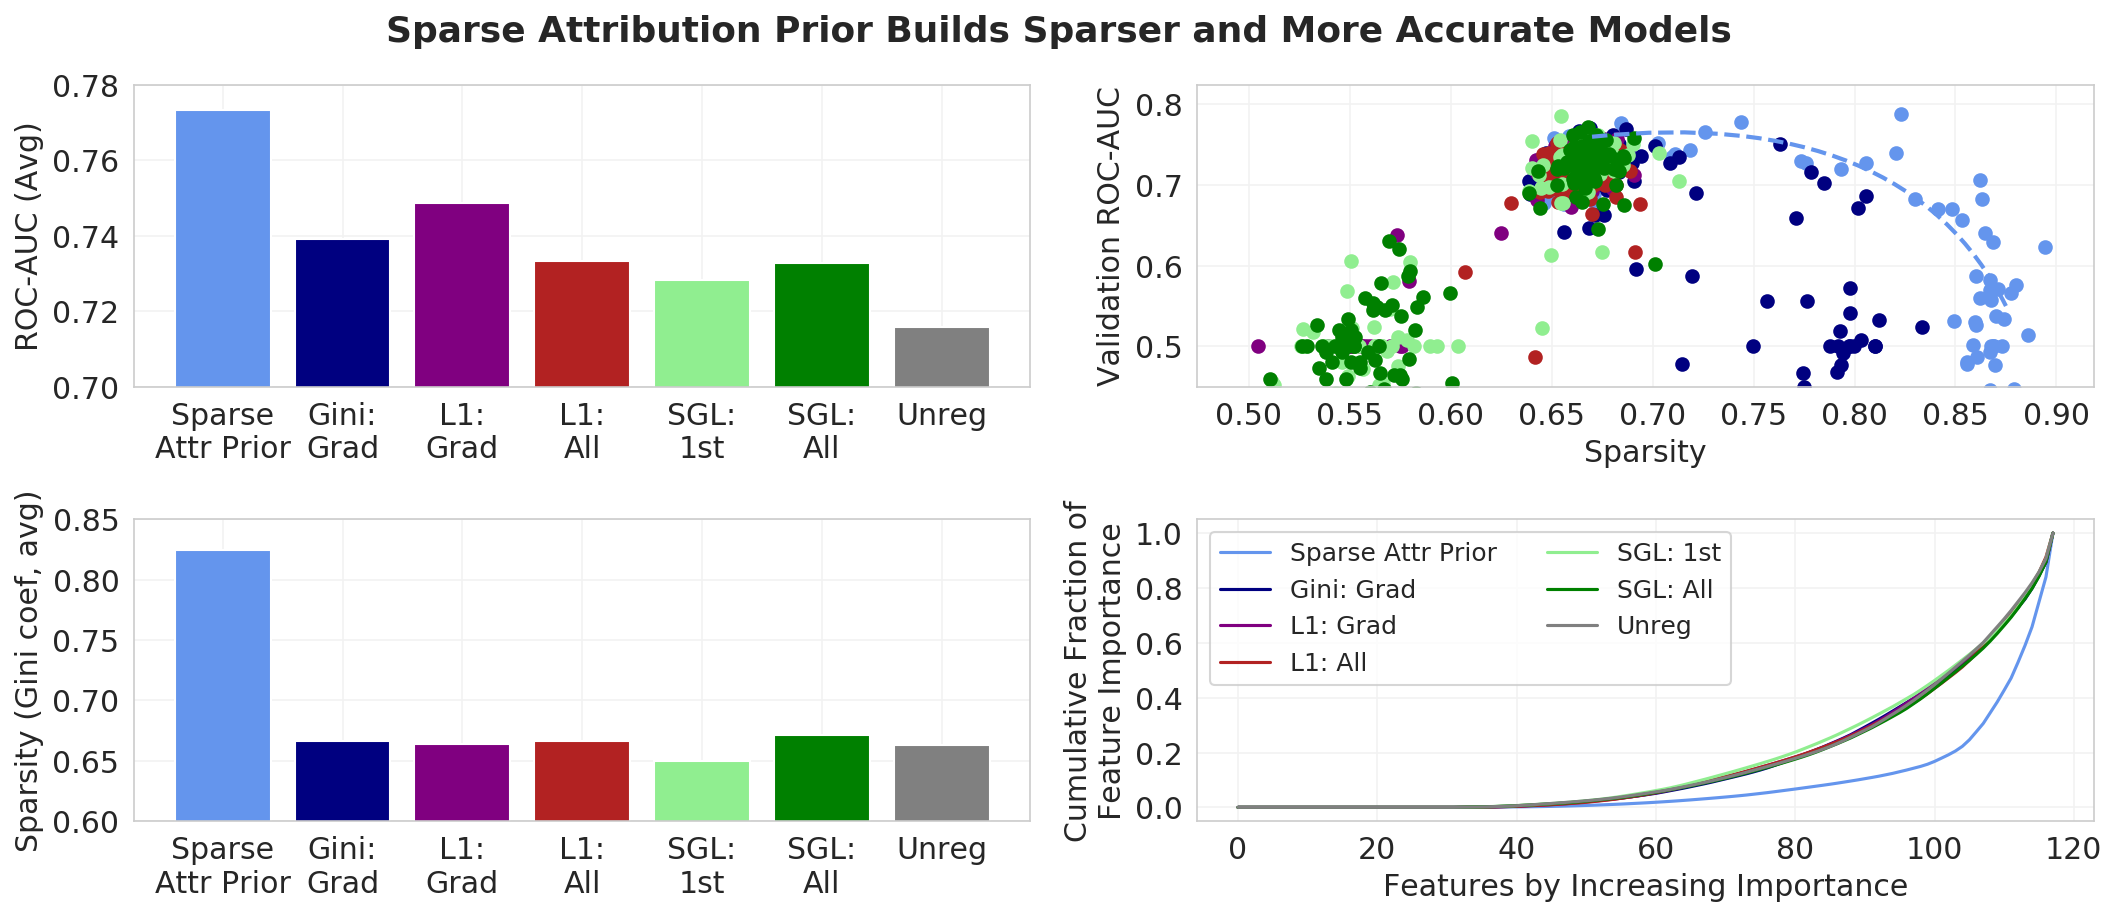

In [32]:
# Generate plot
msort = ['gini','ginigrad','l1grad','l1','sgl','newsgl','unreg']

sns.set_style("whitegrid",{'grid.color':'.95'})
fig, axarr = plt.subplots(2,2,figsize=(14,6),dpi=150,constrained_layout=True)
fig.suptitle("Sparse Attribution Prior Builds Sparser and More Accurate Models",fontsize='xx-large',fontweight='bold')
from scipy.stats import sem
# plt.figure(figsize=(12,3),dpi=150)
axarr[0,0].bar(np.arange(len(msort)),
        [final_test_perf[m].mean() for m in msort], 
        tick_label=[main_map[m] for m in msort],
       color = [color_map[m] for m in msort])
axarr[0,0].errorbar(np.arange(len(msort)),
             [final_test_perf[m].mean() for m in msort],
             yerr=[sem(final_test_perf[m]) for m in msort], 
             fmt='none',color='black')
axarr[0,0].set_ylim(0.7,0.78)
axarr[0,0].set_ylabel("ROC-AUC (Avg)",fontsize='x-large')
axarr[1,0].bar(np.arange(len(msort)),
        [final_test_gini[m].mean() for m in msort], 
        tick_label=[main_map[m] for m in msort],
       color = [color_map[m] for m in msort])
axarr[1,0].errorbar(np.arange(len(msort)),
             [final_test_gini[m].mean() for m in msort],
             yerr=[sem(final_test_gini[m]) for m in msort], 
             fmt='none',color='black')
axarr[1,0].set_ylim(0.6,0.85)
axarr[1,0].set_ylabel("Sparsity (Gini coef, avg)",fontsize='x-large')

for m in msort:
    shap_cdf_plot(np.mean(np.sort(final_test_shaps[m],axis=1),axis=0),axarr[1,1],label=main_map[m].replace('\n',' '),color=color_map[m])
axarr[1,1].legend(fontsize='large',loc='upper left',ncol=2)
axarr[1,1].set_xlabel("Features by Increasing Importance",fontsize='x-large')
axarr[1,1].set_ylabel("Cumulative Fraction of\nFeature Importance",fontsize='x-large')

for m in msort[:-1]:
    int_res = np.dstack([r.values for r in results[m]])
    means = np.nanmean(int_res,axis=2)[:,[1,2]]
    axarr[0,1].scatter(means[:,0],means[:,1],color=color_map[m],label=main_map[m])
axarr[0,1].set_xlabel("Sparsity",fontsize='x-large')
axarr[0,1].set_ylabel("Validation ROC-AUC",fontsize='x-large')
axarr[0,1].set_ylim(0.45)
codes = [
    Path.MOVETO,
    Path.CURVE3,
    Path.CURVE3
]
verts = [(0.67,0.76),(0.825,0.8),(0.875,0.55)]
path = Path(verts,codes)
patch = patches.PathPatch(path, facecolor='none', edgecolor='cornflowerblue', lw=2, linestyle='--')
axarr[0,1].add_patch(patch)
# axarr[0,1].annotate("Smooth sparsity-\nAUC tradeoff", 
#                     xy=(0.8,0.71), xytext=(0.65,0.52),fontsize='x-large',
#                     arrowprops=dict(arrowstyle="->",fc='cornflowerblue',ec='cornflowerblue'))
for ax in axarr.flatten(): 
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize('x-large') 
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize('x-large') 